# M3: Targeted to Global Conversion
spectra means reflectance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# import os ; replaced below
from pathlib import Path

In [78]:
# consider simplifying to assume input files and if not found, create
# modify to match SEARCH_MSG_OUT with save path behavior

SEARCH_MSG_IN = \
    f"> Select a folder to add it to the path and search inside.\n" \
    f"> Select a file to finish the search process.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit\n" \
    f"[U] Search up one level"

def findFile(input_path):
    current_path = Path(input_path)
    if not current_path.exists(): return(f"Invalid Path: {current_path}")

    print(f"Current path: {current_path}")
    print(SEARCH_MSG_IN)

    file_list = [f for f in current_path.iterdir()]
    print("--- Files in current folder:")
    for id, file_path in enumerate(file_list):
        print(f"[{id}] {file_path.name}")
    print("")

    choice = input().lower()
    while choice not in ["u", "e"] + [str(i) for i in range(len(file_list))]:
        choice = input("Couldn't read input, trying again. Target #: ").lower()

    if choice == "e": return("Exiting.")
    if choice == "u": return(findFile(current_path.parent))
    if choice.isnumeric() and int(choice) in range(len(file_list)):
        current_path = current_path / file_list[int(choice)]
        if current_path.is_dir(): return(findFile(current_path))
        elif current_path.is_file(): return current_path

    return("Error reading path, exiting.")

In [79]:
data_path = findFile(Path.cwd())
print(f"Path selected: {data_path}")

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/scripts
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
--- Files in current folder:
[0] su25 script.ipynb
[1] wi25 lab data script.ipynb
[2] wi25 lab data script.py

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
--- Files in current folder:
[0] .DS_Store
[1] input files
[2] README.md
[3] m3venv
[4] .gitignore
[5] output files
[6] scripts
[7] .git

Path selected: Exiting.


In [ ]:
if data_path != Path.cwd().parent / Path('output files/csvs/Pyroxene lab spectra FDL/USGS augite WS592.csv'):
    print("path updated")
    data_path = Path.cwd().parent / Path('output files/csvs/Pyroxene lab spectra FDL/USGS augite WS592.csv')
else:
    print("path unchanged")
print(f"{data_path}")

In [20]:
df = pd.read_csv(data_path).dropna()

In [21]:
df.head()

,Wavelength (µm) raw,Augite ws592 spliced raw,Wavelength (µm) bin avg,Augite ws592 spliced bin avg
0,0.3011,0.045344,0.44602,0.207174
1,0.3051,0.047974,0.45600,0.214279
2,0.3091,0.049266,0.46598,0.220972
3,0.3131,0.054325,0.47596,0.229766
4,0.3171,0.058099,0.48595,0.239917


In [22]:
df.describe()

,Wavelength (µm) raw,Augite ws592 spliced raw,Wavelength (µm) bin avg,Augite ws592 spliced bin avg
count,255.000000,255.000000,255.000000,255.000000
mean,0.620815,0.269861,1.721942,0.382425
std,0.190423,0.079091,0.738549,0.111185
min,0.301100,0.045344,0.446020,0.169067
25%,0.476300,0.230379,1.089790,0.309022
50%,0.602700,0.304953,1.723590,0.387403
75%,0.733000,0.318236,2.357380,0.470706
max,1.073500,0.380363,2.991170,0.556277


In [23]:
# process:
# change step size if past a breakpoint
# format:
# current wl: step to transition to
breakpoints = {
    "wl"   : [0, 0.44, 0.68, 0.71, 1.53, 1.56, 1.60], # 9999],
    "step" : [0,    4,    4,    3,    2,    3,    4]  #    4]
}

WL_COL = -1
SPECTRA_COL = -1

print(f"[#] column name")
for i in range(len(df.columns)):
    print(f"[{i+1}] {df.columns[i]}")

try:
    ans = input('Select wavelength column #')
    WL_COL = int(ans)-1
    if WL_COL not in range(len(df.columns)):
        raise ValueError(f"{ans} out of column range")
    else:
        print(f"> Selected [{ans}] {df.columns[WL_COL]} for wavelength column")
except Exception as e:
    print(f"> Unrecognized #, {e}")

try:
    ans = input('Select spectra column #')
    SPECTRA_COL = int(ans)-1
    if SPECTRA_COL not in range(len(df.columns)):
        raise ValueError(f"{ans} out of column range")
    else:
        print(f"> Selected [{ans}] {df.columns[SPECTRA_COL]} for spectra column")
except Exception as e:
    print(f"> Unrecognized #, {e}")


try:
    wavelengths = np.array(df[df.columns[WL_COL]])
except:
    print(f"wavelength column not found")

wl_nans = np.isnan(wavelengths).sum()
if wl_nans > 0:
    print(f"wl shape: {wavelengths.shape}")
    print(f"wavelength nans: {np.isnan(wavelengths).sum()}")
    print(f"wavelength nan indices: {np.where(np.isnan(wavelengths))[0]}")


try:
    spectra = np.array(df[df.columns[SPECTRA_COL]])
except:
    print(f"spectra column not found")

spectra_nans = np.isnan(spectra).sum()
if spectra_nans > 0:
    print(f"spectra shape: {spectra.shape}")
    print(f"spectra nans: {np.isnan(spectra).sum()}")
    print(f"spectra nan indices: {np.where(np.isnan(spectra))[0]}")

[#] column name
[1] Wavelength (µm) raw
[2] Augite ws592 spliced raw
[3] Wavelength (µm) bin avg
[4] Augite ws592 spliced bin avg
> Selected [3] Wavelength (µm) bin avg for wavelength column
> Selected [4] Augite ws592 spliced bin avg for spectra column


In [ ]:
def targeted_to_global(wavelengths, values, verbose = False):
    # average 4 at a time
    # set step size to last breakpoint
    # increment by step size
    # round to 4 decimals

    WIDTH = 7
    if verbose: print(f"{'wl':>{WIDTH}}: step, index change")

    i = 0 # input index
    bp_idx = 0
    output = {"wavelengths": [], "values": []}
    while i+3 < len(wavelengths):
        # average over next 4
        avg_wl = np.round(np.mean(wavelengths[i:i+4]),4)
        avg_values = np.round(np.mean(values[i:i+4]),4)

        # if next step exists
        # and current wl > bp_idx wl
        while bp_idx + 1 < len(breakpoints["step"]) and wavelengths[i] > breakpoints["wl"][bp_idx]:
            bp_idx += 1
            if verbose: print(f"{wavelengths[i]:{WIDTH}.{WIDTH-2}f}: {breakpoints['step'][bp_idx-1]}->{breakpoints['step'][bp_idx]}, {bp_idx-1}->{bp_idx}")

        # save and increment by values consumed
        output["wavelengths"].append(avg_wl)
        output["values"].append(avg_values)
        i += breakpoints["step"][bp_idx]
    
    output["wavelengths"] = np.array(output["wavelengths"])
    output["values"] = np.array(output["values"])
    return output

In [25]:
targeted_to_global(wavelengths, spectra, verbose=True)

     wl: step, index change
0.44602: 0->4, 0->1
0.44602: 4->4, 1->2
0.68556: 4->3, 2->3
0.71551: 3->2, 3->4
1.54393: 2->3, 4->5
1.57387: 3->4, 5->6


{'wavelengths': array([0.461 , 0.5009, 0.5408, 0.5808, 0.6207, 0.6606, 0.7005, 0.7305,
        0.7504, 0.7704, 0.7904, 0.8103, 0.8303, 0.8527, 0.8777, 0.9002,
        0.9201, 0.9401, 0.96  , 0.98  , 1.    , 1.0199, 1.0399, 1.0598,
        1.0798, 1.0998, 1.1197, 1.1397, 1.1597, 1.1796, 1.1996, 1.2196,
        1.2395, 1.2595, 1.2794, 1.2994, 1.3194, 1.3393, 1.3593, 1.3792,
        1.3992, 1.4192, 1.4391, 1.4591, 1.479 , 1.499 , 1.519 , 1.5389,
        1.5589, 1.5888, 1.6288, 1.6687, 1.7086, 1.7485, 1.7885, 1.8284,
        1.8683, 1.9082, 1.9482, 1.9881, 2.028 , 2.0679, 2.1078, 2.1478,
        2.1877, 2.2276, 2.2676, 2.3075, 2.3474, 2.3873, 2.4272, 2.4672,
        2.5071, 2.547 , 2.5869, 2.6269, 2.6668, 2.7067, 2.7466, 2.7866,
        2.8265, 2.8664, 2.9063, 2.9463]),
 'spectra': array([0.218 , 0.2587, 0.3048, 0.3172, 0.3073, 0.3084, 0.3239, 0.3411,
        0.3514, 0.3599, 0.3676, 0.3744, 0.3787, 0.3751, 0.359 , 0.3368,
        0.3159, 0.292 , 0.2689, 0.2546, 0.2453, 0.2406, 0.2443, 0.25

In [26]:
### inconsistencies
## round up, not truncating
# mean(0.99497, 1.005, 1.0149, 1.0249) = 1.0099425 -> 1.0099, manual is 1.01 > 1.0099
## round down
# mean(2.3624, 2.3724, 2.3823, 2.3923) = 2.37735 -> 2.3774, manual is 2.3773 < 2.3774

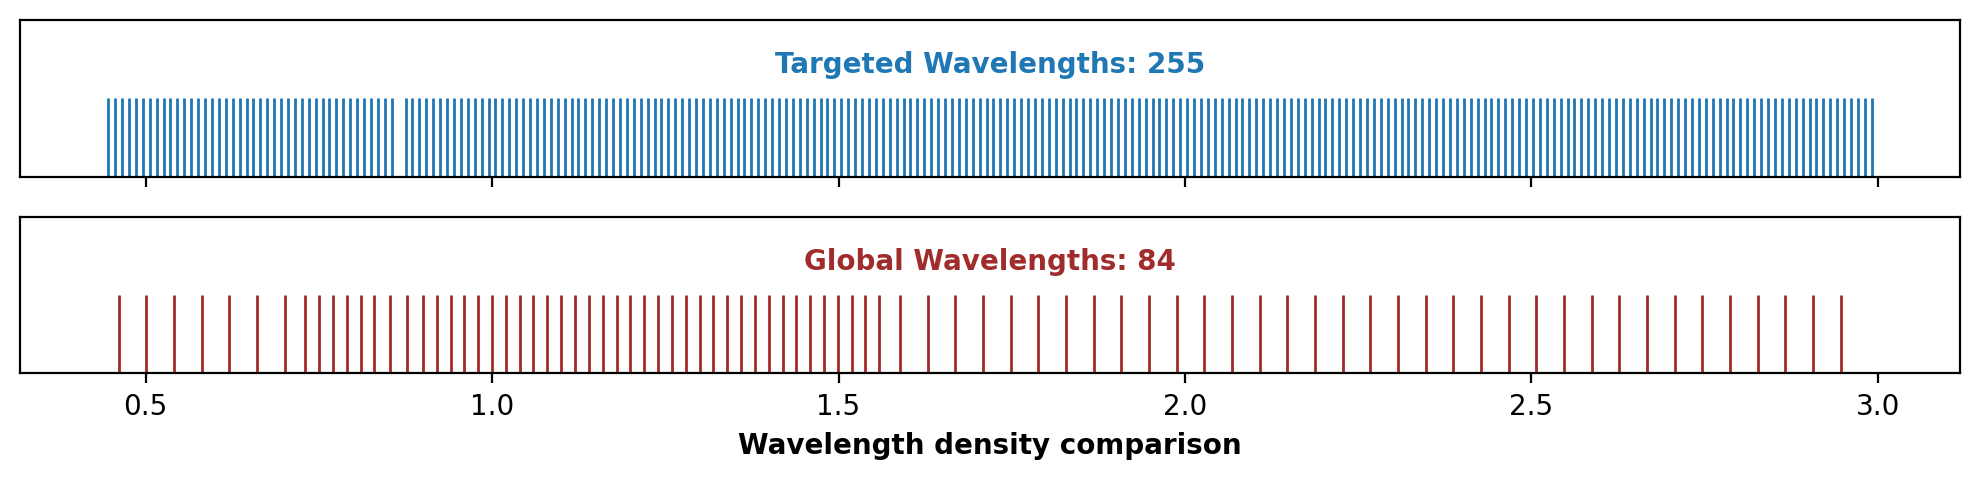

In [38]:
plotting = True
saving = False
if plotting:

    data = {
        "Targeted Wavelengths": wavelengths, 
        "Global Wavelengths": targeted_to_global(wavelengths, spectra)["wavelengths"]
    }

    colors = ['#1f77b4', "#a02c2c"]
    fig, axes = plt.subplots(
        nrows=2,
        sharex=True, 
        figsize=(10, 2.5), 
        height_ratios=[1, 1]
    )

    # each series as a rug plot with its own row
    for ax, (label, series), color in zip(axes, data.items(), colors):
        sns.rugplot(x = series, ax = ax, height = 0.5, color = color)
        ax.set_yticks([])  # No y-axis ticks
        ax.set_ylabel("")
        ax.text(
            0.5, # x offset
            0.8, # y offset
            f"{label}: {series.shape[0]}", # text content
            # **kwargs
            transform=ax.transAxes, 
            ha='center', 
            va='top', 
            fontsize=10, 
            color=color, 
            weight='bold'
        )

    # last plot label acts as legend label
    axes[-1].set_xlabel("Wavelength density comparison", weight = 'bold') 
    plt.tight_layout()

    if saving:
        plt.savefig(
            "../output files/graphs/test/m3 wavelength comparison.png", 
            dpi=2000, 
            bbox_inches='tight',
            facecolor='white'
        )

    plt.show() # calls plt.clf()

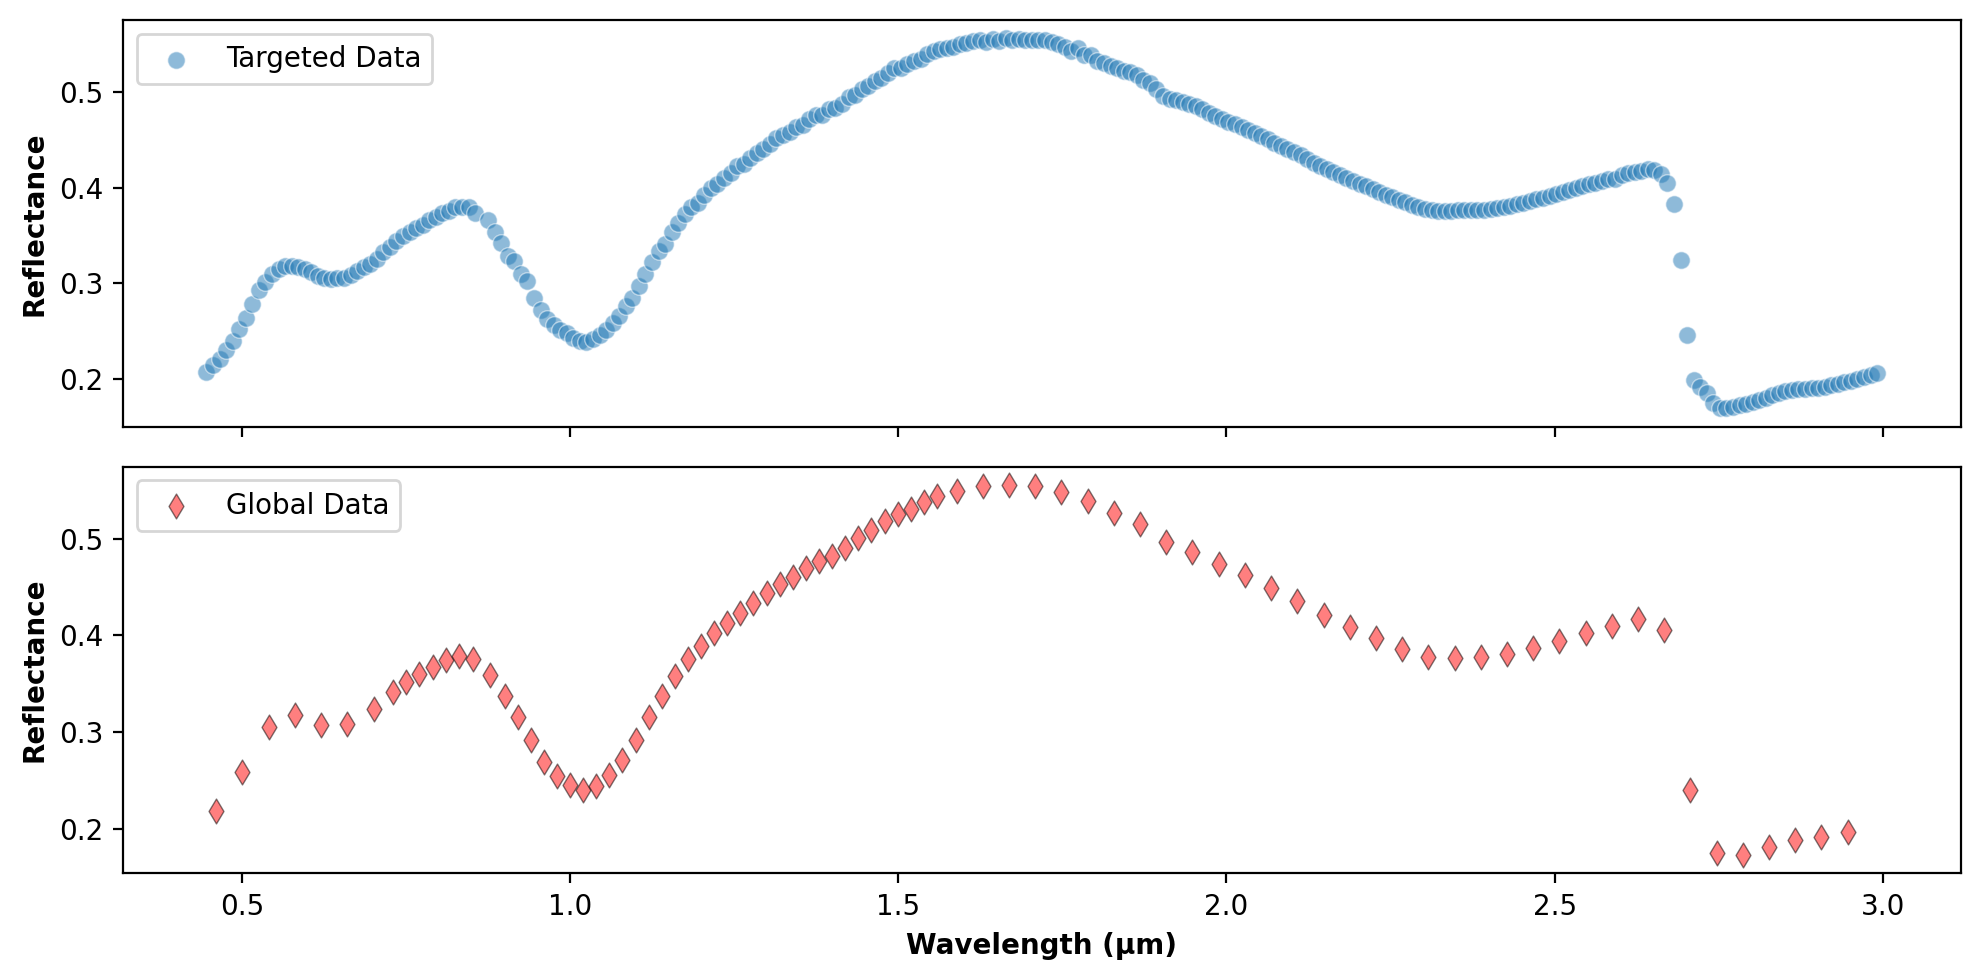

In [ ]:
plotting = True
saving = False
if plotting:

    data = {
        "Targeted Data": {'wavelengths':wavelengths, 'spectra':spectra},
        "Global Data": targeted_to_global(wavelengths, spectra)
    }

    colors = ['#1f77b4', "#FF0000"]
    markers = ['o', 'd']
    sizes = [40, 40]
    edgecolors = ['white', 'black']

    fig, axes = plt.subplots(
        nrows = 2,
        sharex=True, 
        figsize=(10, 5), 
        height_ratios=[1,1]
    )

    for ax, (label, contents), color, marker, size, edge in zip(axes, data.items(), colors, markers, sizes, edgecolors):
        sns.scatterplot(
            ax = ax,
            x = contents['wavelengths'], 
            y = contents['spectra'],
            color = color,
            marker = marker,
            edgecolor = edge,
            s = size,
            alpha = 0.5,
            label = label
        )
        ax.set_ylabel("Reflectance", weight='bold')
        ax.legend(loc='upper left')

    # last plot label acts as legend label
    axes[-1].set_xlabel("Wavelength (µm)", weight = 'bold')
    # fig.suptitle(f"{data_path.stem}")
    plt.tight_layout()
    
    if saving: plt.savefig(
        Path(*[i if i != 'csvs' else 'graphs' for i in list(data_path.parts)]).with_suffix(".png"),
        dpi=2000, 
        bbox_inches='tight',
        facecolor='white'
    )

    plt.show() # calls plt.clf()

In [ ]:
### file writing:
# check if output files/data_path exists
# prompt to create
# write file to output_path

# def guess_output_path(input_path):
#     parts = list(input_path.parts)
#     for i in range(len(parts)-1,-1,-1):
#         if parts[i] == "input files":
#             return Path(*parts[:i]) / "output files"

# def prompt_output_path(input_path):
#     print("Folder 'output files' not found, create one (Y/N)? ")
#     ans = input()
#     while ans.lower() not in ["y", "n", "e"]:
#         ans = input()
#     if ans.lower() != "y":
#         return None

#     print("Enter # to create 'output files' folder in corresponding parent folder.")
#     print("[#] folder name")
#     for c, i in enumerate(output_path.parts):
#         print(f"[{c}] {i}")
#     ans = input()
#     return Path(*list(output_path.parts)[:c]) / "output files"

def writeFile(data, filename, output_path, mode): 
    # x - new, w - overwrite
    output = open(output_path / filename, mode)
    output.write(f"header")
    for i in data:
        output.write(f"data formatted")
    output.close()

In [73]:
# consider simplifying to assume output and if not found, create

SEARCH_MSG_OUT = \
    f"> Construct the desired output path by selecting files/folders.\n" \
    f"> Save the path to end search.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit without saving\n" \
    f"[S] Save current path\n" \
    f"[U] Search up one level"

def findOutputFolder(input_path):
    current_path = Path(input_path)
    if not current_path.exists(): return("Invalid Path")
    
    print(f"Current path: {current_path}")
    print(SEARCH_MSG_OUT)
    
    # list out folders with [#] as identifier
    folder_list = [f for f in current_path.iterdir() if f.is_dir()]
    print("> Folders in current folder:")
    if len(folder_list) == 0: print("[#] No folders found.")
    for c, i in enumerate(folder_list):
        print(f"[{c}] {i.name}")
    print("")

    choice = input().lower()
    while choice not in ["e", "s", "u"] + [str(i) for i in range(len(folder_list))]:
        choice = input("Couldn't read input, trying again. Target #: ").lower()

    if choice.lower() == "e": return("Exiting.")
    if choice.lower() == "s": return(current_path)
    if choice.lower() == "u": return(findOutputFolder(current_path.parent))
    if choice.isnumeric() and int(choice) in range(len(folder_list)):
        current_path = current_path / folder_list[int(choice)]
        if current_path.is_dir():
            return(findOutputFolder(current_path))

    return("Error reading choice, exiting.")

In [74]:
# print(SEARCH_MSG_OUT)
output_path = findOutputFolder(data_path.parent)
print(f"Path selected: {output_path}")

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/output files/targeted csvs/Pyroxene lab spectra FDL
> Construct the desired output path by selecting files/folders.
> Save the path to end search.
> To select option [#], enter #.
[E] Exit without saving
[S] Save current path
[U] Search up one level
> Folders in current folder:
[#] No folders found.

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/output files/targeted csvs
> Construct the desired output path by selecting files/folders.
> Save the path to end search.
> To select option [#], enter #.
[E] Exit without saving
[S] Save current path
[U] Search up one level
> Folders in current folder:
[0] Feldspar lab spectra FDL
[1] Olivine lab spectra FDL
[2] Pyroxene lab spectra FDL
[3] Glass_volcanics
[4] 20250222 USGS

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/output files
> Construct the desired output path by selecting files/folders.
> Save the path to end 

In [75]:
output_data = targeted_to_global(wavelengths, spectra, verbose=False)

In [ ]:
try:
    writeFile(output_data, data_path.name, output_path, mode = "x")
except FileExistsError:
    print(f"File path already exists, overwrite (Y/N)?")
    ans = input()
    while ans.lower() not in ["y", "n"]:
        ans = input()
    if ans.lower() == "y":
        writeFile(output, filename, output_path, mode = "w")